### Imports

In [1]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/raw/AWS_Honeypot_marx-geo.csv')
df.head()

,datetime,host,src,proto,type,spt,dpt,srcstr,cc,country,locale,localeabbr,postalcode,latitude,longitude,Unnamed: 15
0,3/3/13 21:53,groucho-oregon,1032051418,TCP,NaN,6000.0,1433.0,61.131.218.218,CN,China,Jiangxi Sheng,36,NaN,28.5500,115.9333,NaN
1,3/3/13 21:57,groucho-oregon,1347834426,UDP,NaN,5270.0,5060.0,80.86.82.58,DE,Germany,NaN,NaN,NaN,51.0000,9.0000,NaN
2,3/3/13 21:58,groucho-oregon,2947856490,TCP,NaN,2489.0,1080.0,175.180.184.106,TW,Taiwan,Taipei,NaN,NaN,25.0392,121.5250,NaN
3,3/3/13 21:58,groucho-us-east,841842716,UDP,NaN,43235.0,1900.0,50.45.128.28,US,United States,Oregon,OR,97124,45.5848,-122.9117,NaN
4,3/3/13 21:58,groucho-singapore,3587648279,TCP,NaN,56577.0,80.0,213.215.43.23,FR,France,NaN,NaN,NaN,48.8600,2.3500,NaN


### Helper Function & Data Manipulation

Helper functions to change the data format.

In [3]:
import datetime

def strip_datetime(date):
    """
    Helper function to strip datetime column into components
    """
    return datetime.datetime.strptime(date, "%m/%d/%y %H:%M")

In [4]:
df['date_stripped'] = df['datetime'].apply(strip_datetime)

In [5]:
def get_date(date):
    """
    Helper function to get date without time for easier grouping
    """
    return date.date()#.strftime('%d %b %Y')

In [6]:
df['date'] = df['date_stripped'].apply(get_date)

In [7]:
def read_date(date):
    """
    Helper function to get a more readable datetime object
    """
    return date.strftime('%d %b %Y')

In [8]:
read_date(min(df['date']))

'03 Mar 2013'

In [9]:
read_date(max(df['date']))

'08 Sep 2013'

In [10]:
df['month'] = df['date'].apply(lambda x: x.month)

In [11]:
# Visualizing number of attacks per day grouped by month. 

### EDA

Plot of the number of attacks per day for each day in the dataset. The plots are grouped by different months. The goal here was to try and see if certain days had more attacks which we did find peak. But could not find any correlations between those peaks and current events in the world. 

#### Timeline of Attacks

From the graphs below we see the timeline of the number of attacks. We can see that in some months for some days there are peaks where there are a more than usual number of attacks. For example 3/18/23, 7/24/23, 8/26/23 and 8/27/23 are all spikes where there are more attacks than usual. 

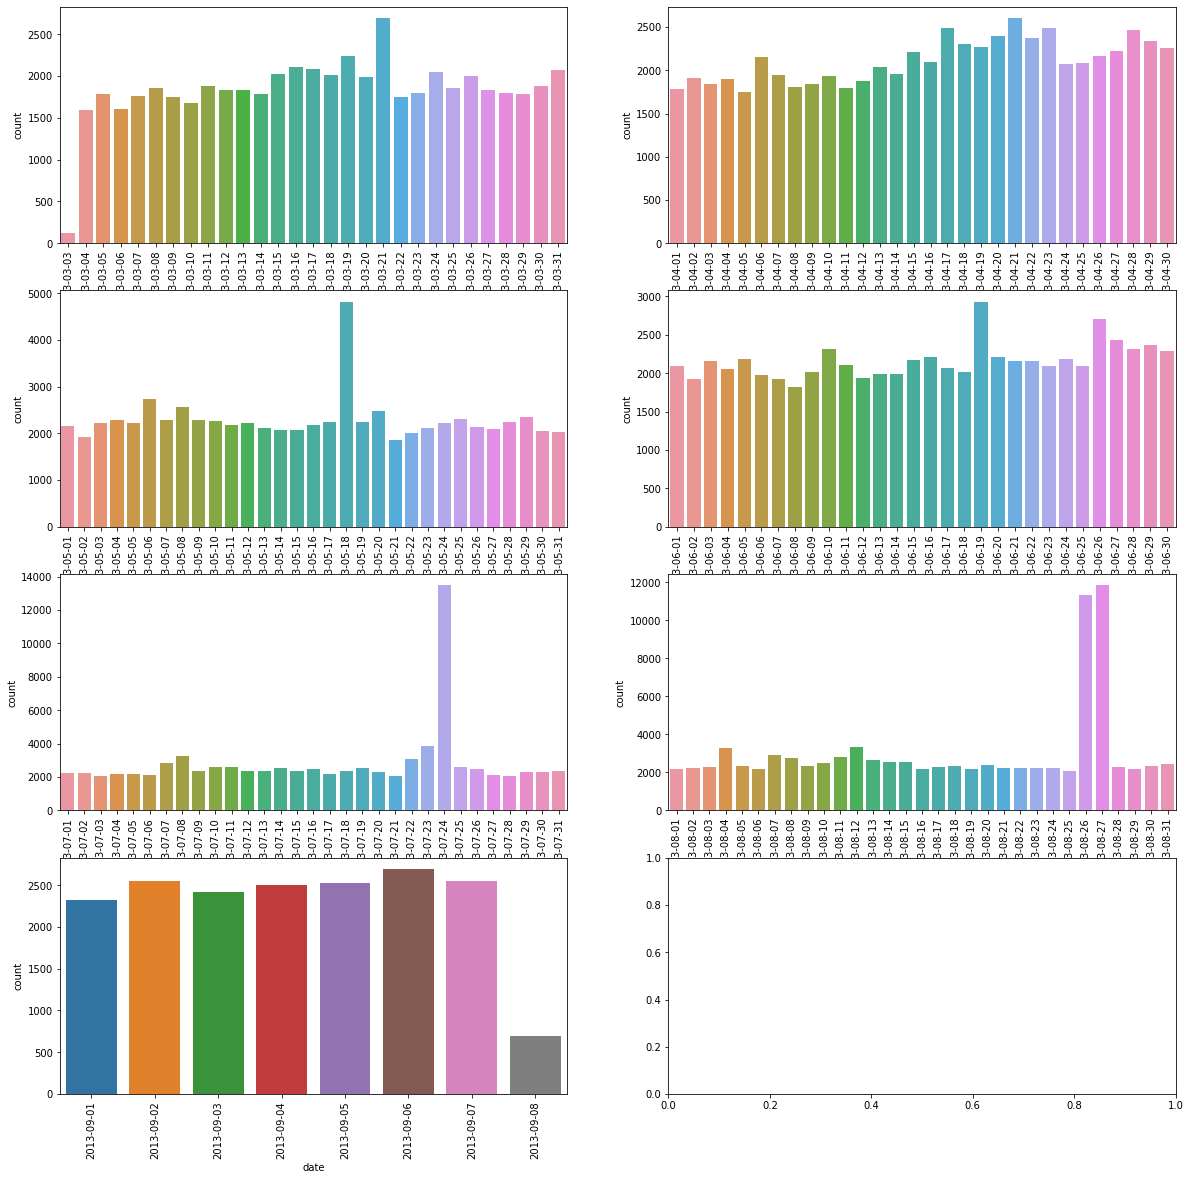

In [12]:
fig, axs = plt.subplots(4, 2)
fig.set_size_inches(20, 20)

max_by_month = []

count = 0
for month, group in df.groupby('month'):
    max_by_month.append(group['date'].mode()[0])
    if count == 0:
        x, y = 0, 0
    else:
        x, y = math.floor(count / 2), count % 2
    axs[x, y].tick_params(axis='x', rotation=90)
    sns.countplot(x='date', data=group, ax=axs[x, y])
    count += 1

#### Deeper into Key Dates

In the eda below we are trying to get a better idea of what is going on in the days where there are peaks in the number of attacks. 

In [13]:
max_by_month[4].strftime('%d %b %Y')

'24 Jul 2013'

In [14]:
#get dataframe of max of july month
max_july = df.loc[df['date'] == max_by_month[4]]

<Axes: xlabel='proto'>

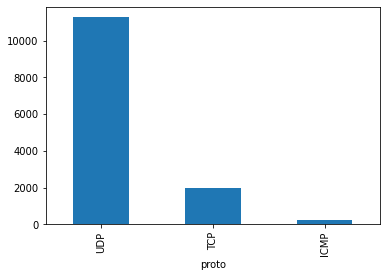

In [15]:
max_july['proto'].value_counts().plot(kind='bar')

<Axes: xlabel='host'>

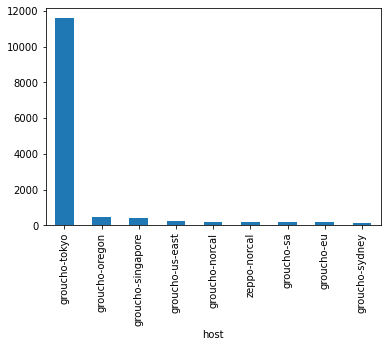

In [16]:
max_july['host'].value_counts().plot(kind='bar')

<Axes: xlabel='country'>

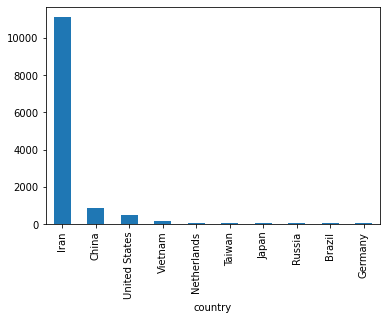

In [17]:
max_july['country'].value_counts().head(10).plot(kind='bar')

<Axes: xlabel='srcstr'>

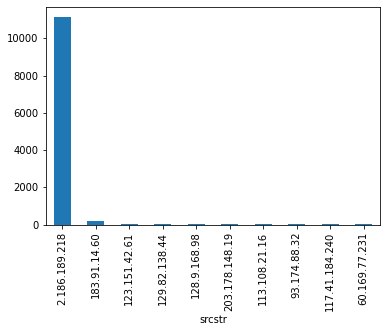

In [18]:
max_july['srcstr'].value_counts().head(10).plot(kind='bar')

Most of the attacks came from one source. Here im trying to find other instances where we get the same source of attacks from other months. Could not find any other attacks from the same source on different days or months. 

In [19]:
max_source_july = max_july['srcstr'].mode()[0]

In [20]:
df[df['srcstr'] == max_source_july]['month'].value_counts()

month
7    11116
Name: count, dtype: int64

In [21]:
df[df['srcstr'] == max_source_july]['date'].value_counts()

date
2013-07-24    11116
Name: count, dtype: int64

Did not find any other instances of attacks from the same source. There are two peaks in the month of august we are going to take a look at. 

In [22]:
aug_peak_one = max_by_month[5]

In [23]:
from datetime import timedelta

aug_peak_two = max_by_month[5] - timedelta(days=1)

In [24]:
peak_one_str = aug_peak_one.strftime('%d %b %Y')
peak_two_str = aug_peak_two.strftime('%d %b %Y')

In [25]:
peak_one_df = df.loc[df['date'] == max_by_month[5]]
peak_two_df = df.loc[df['date'] == max_by_month[5] - timedelta(days=1)]

<Axes: title={'center': 'Plot for 26 Aug 2013'}, xlabel='proto'>

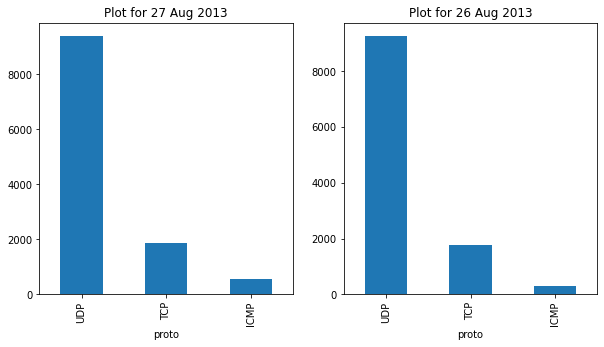

In [26]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

axs[0].set_title('Plot for ' + peak_one_str)
axs[1].set_title('Plot for ' + peak_two_str)

peak_one_df['proto'].value_counts().plot(kind='bar', ax=axs[0])
peak_two_df['proto'].value_counts().plot(kind='bar', ax=axs[1])

<Axes: title={'center': 'Plot for 26 Aug 2013'}, xlabel='host'>

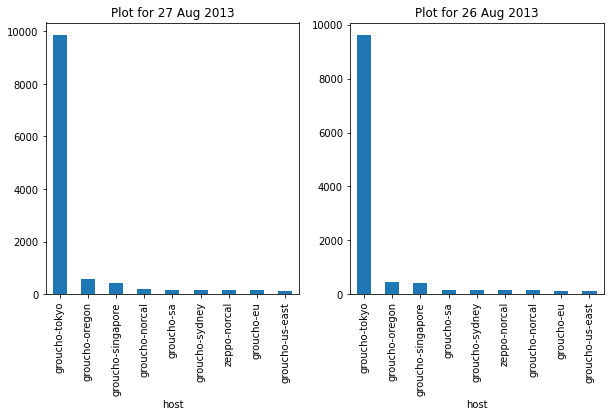

In [27]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

axs[0].set_title('Plot for ' + peak_one_str)
axs[1].set_title('Plot for ' + peak_two_str)

peak_one_df['host'].value_counts().plot(kind='bar', ax=axs[0])
peak_two_df['host'].value_counts().plot(kind='bar', ax=axs[1])

<Axes: title={'center': 'Plot for 26 Aug 2013'}, xlabel='country'>

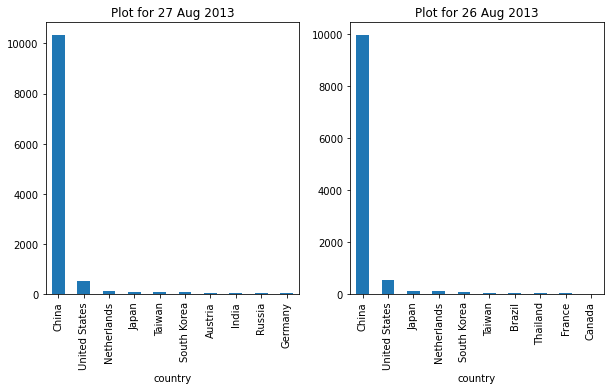

In [28]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

axs[0].set_title('Plot for ' + peak_one_str)
axs[1].set_title('Plot for ' + peak_two_str)

peak_one_df['country'].value_counts().head(10).plot(kind='bar', ax=axs[0])
peak_two_df['country'].value_counts().head(10).plot(kind='bar', ax=axs[1])

<Axes: title={'center': 'Plot for 26 Aug 2013'}, xlabel='srcstr'>

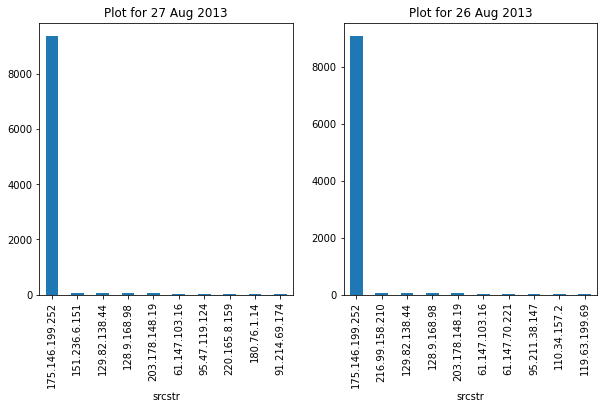

In [29]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

axs[0].set_title('Plot for ' + peak_one_str)
axs[1].set_title('Plot for ' + peak_two_str)

peak_one_df['srcstr'].value_counts().head(10).plot(kind='bar', ax=axs[0])
peak_two_df['srcstr'].value_counts().head(10).plot(kind='bar', ax=axs[1])

In [30]:
peak_one_df['srcstr'].mode()[0]

'175.146.199.252'

In [31]:
peak_two_df['srcstr'].mode()[0]

'175.146.199.252'

Trying to find if this source has had any other attacks on other days other than the peaks we have just found, but we find that this source has not done other attacks. 

In [32]:
df[df['srcstr'] == peak_one_df['srcstr'].mode()[0]]['date'].value_counts()

date
2013-08-27    9372
2013-08-26    9100
Name: count, dtype: int64

<Axes: title={'center': 'Plot for 26 Aug 2013'}, xlabel='spt'>

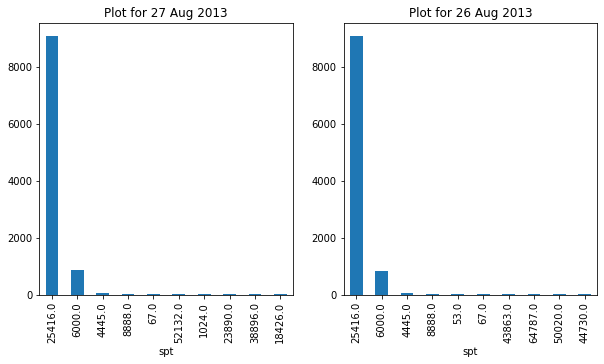

In [33]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

axs[0].set_title('Plot for ' + peak_one_str)
axs[1].set_title('Plot for ' + peak_two_str)

peak_one_df['spt'].value_counts().head(10).plot(kind='bar', ax=axs[0])
peak_two_df['spt'].value_counts().head(10).plot(kind='bar', ax=axs[1])

<Axes: title={'center': 'Plot for 26 Aug 2013'}, xlabel='dpt'>

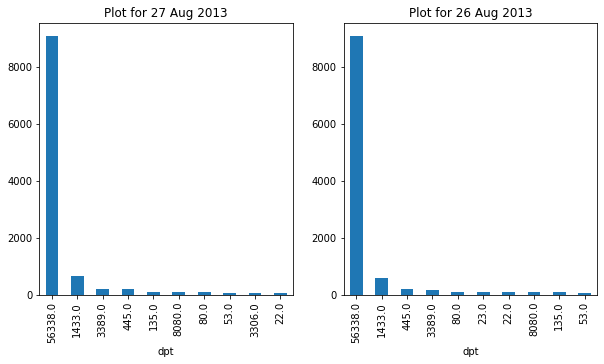

In [34]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

axs[0].set_title('Plot for ' + peak_one_str)
axs[1].set_title('Plot for ' + peak_two_str)

peak_one_df['dpt'].value_counts().head(10).plot(kind='bar', ax=axs[0])
peak_two_df['dpt'].value_counts().head(10).plot(kind='bar', ax=axs[1])

<Axes: xlabel='host'>

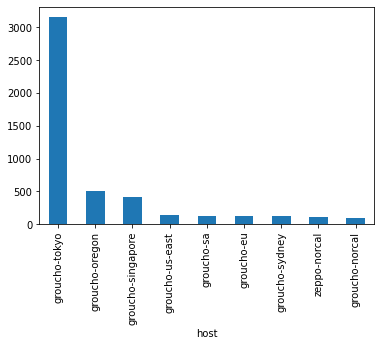

In [35]:
df.loc[df['date'] == max_by_month[2]]['host' ].value_counts().plot(kind='bar')

In [36]:
# attack= df[['latitude','longitude']]
# attack.latitude.fillna(0, inplace = True)
# attack.longitude.fillna(0, inplace = True) 

# World =folium.Map(location=[0,0],zoom_start=2)
# HeatMap(data=attack, radius=16).add_to(World)

# print('Top cyberattacks by country')
# World

Whilst looking at the peak dates where there are more than usual attacks we noticed that in most of these days the attacks are more so coming from one source rather than an influx of different people hacking at the same time. This is very interesting and sort of counterintuitive so it would be worthwile to get a better look at individual hackers rather than dates to try and find some reasons as to why they are hacking. 

#### Focusing On The Top 10 Hackers of Our Honey Pot

This part of the analysis is going to focus more on the source of attacks rather than the actual dates of attacks. 

<Axes: xlabel='srcstr'>

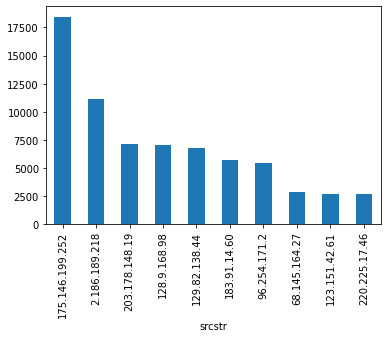

In [36]:
df['srcstr'].value_counts().head(10).plot(kind='bar')

In [37]:
df['srcstr'].value_counts().head(10)

srcstr
175.146.199.252    18472
2.186.189.218      11116
203.178.148.19      7086
128.9.168.98        7046
129.82.138.44       6772
183.91.14.60        5676
96.254.171.2        5413
68.145.164.27       2834
123.151.42.61       2663
220.225.17.46       2605
Name: count, dtype: int64

In [38]:
top_ten_src = list(df['srcstr'].value_counts().head(10).index)

In [39]:
ten_src_df = df[df['srcstr'].isin(top_ten_src)]

In [40]:
ten_src_df['day_hour'] = ten_src_df['date_stripped'].apply(lambda x: (x.day, x.hour))

Plots for the top then src attackers in our honeypot dataset. There are two different patterns either big attacks in a small amount of time span vs sporadic attack patterns with certain peaks. 

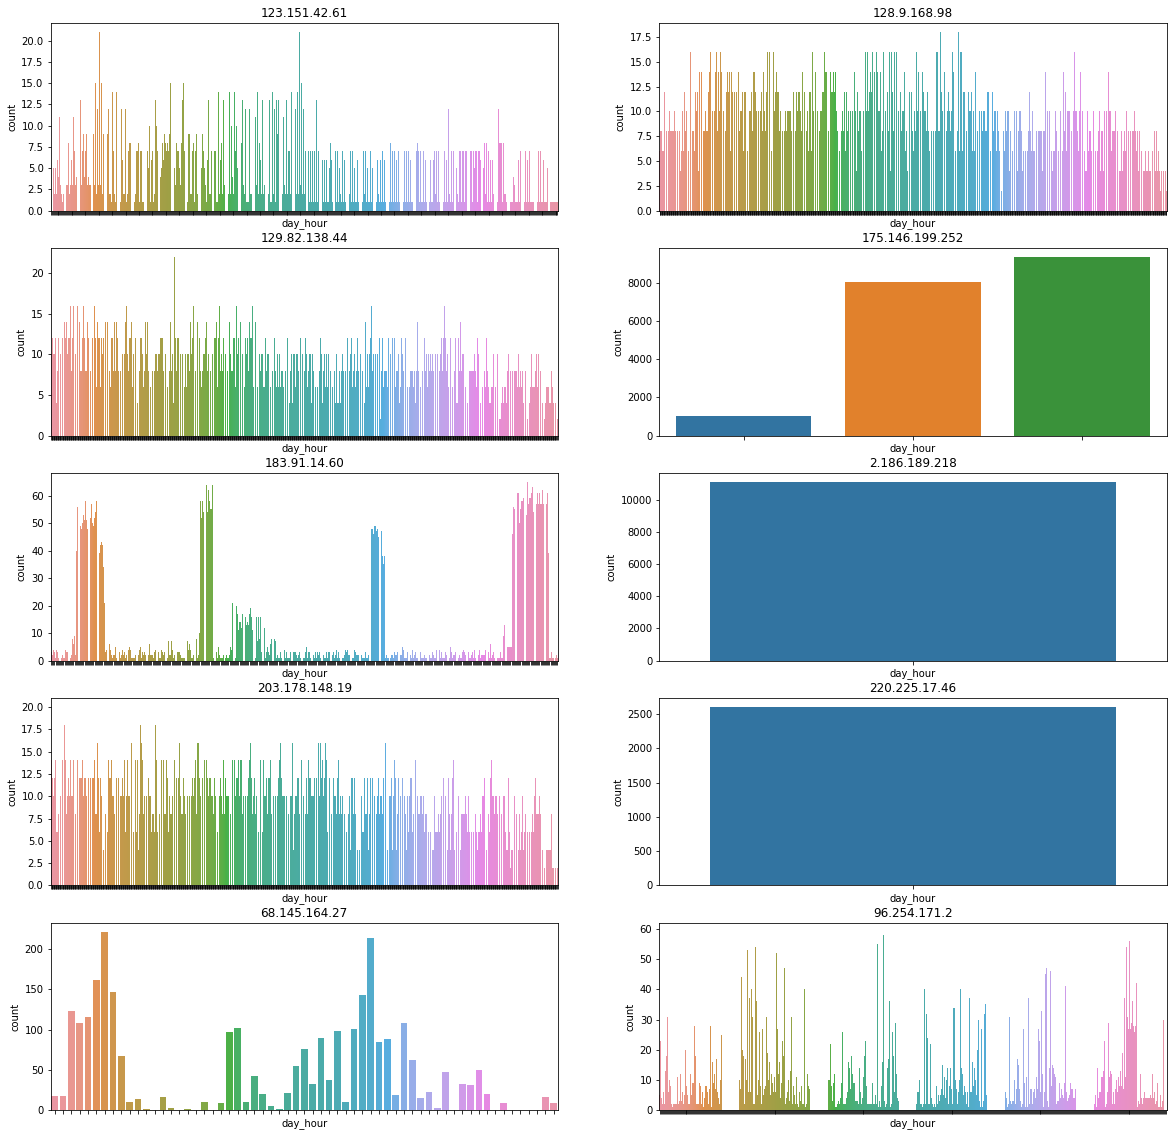

In [41]:
fig, axs = plt.subplots(5, 2)
fig.set_size_inches(20, 20)

count = 0
for srcstr, group in ten_src_df.groupby('srcstr'):
    if count == 0:
        x, y = 0, 0
    else:
        x, y = math.floor(count / 2), count % 2
    plt.setp(axs[x, y].get_xticklabels(), visible=False)
    axs[x, y].title.set_text(srcstr)
    sns.countplot(x='day_hour', data=group, ax=axs[x, y])
    count += 1

As we can see from the graphs above we can distinguish hackers into two different groups in terms of their patterns of attack.
- Group 1: The first hacker is the one that hacks over a long period of time and usually has a pattern. This hacker will have peaks where they hack more than usual but are more consistent in terms of hacking. 
- Group 2: On the other hand we have a hacker that hacks over a short period of time usually doing all his hacking in a matter of a couple of hours. These hackers have thousands of attempts in a short period of time and are never seen again.

In [42]:
df['day_hour'] = df['date_stripped'].apply(lambda x: (x.day, x.hour))

#### Hacking By Host

In the following graphs we take a look at hacking patterns by host location. We can see that most hosts follow the same patterns having different peaks on different days. 

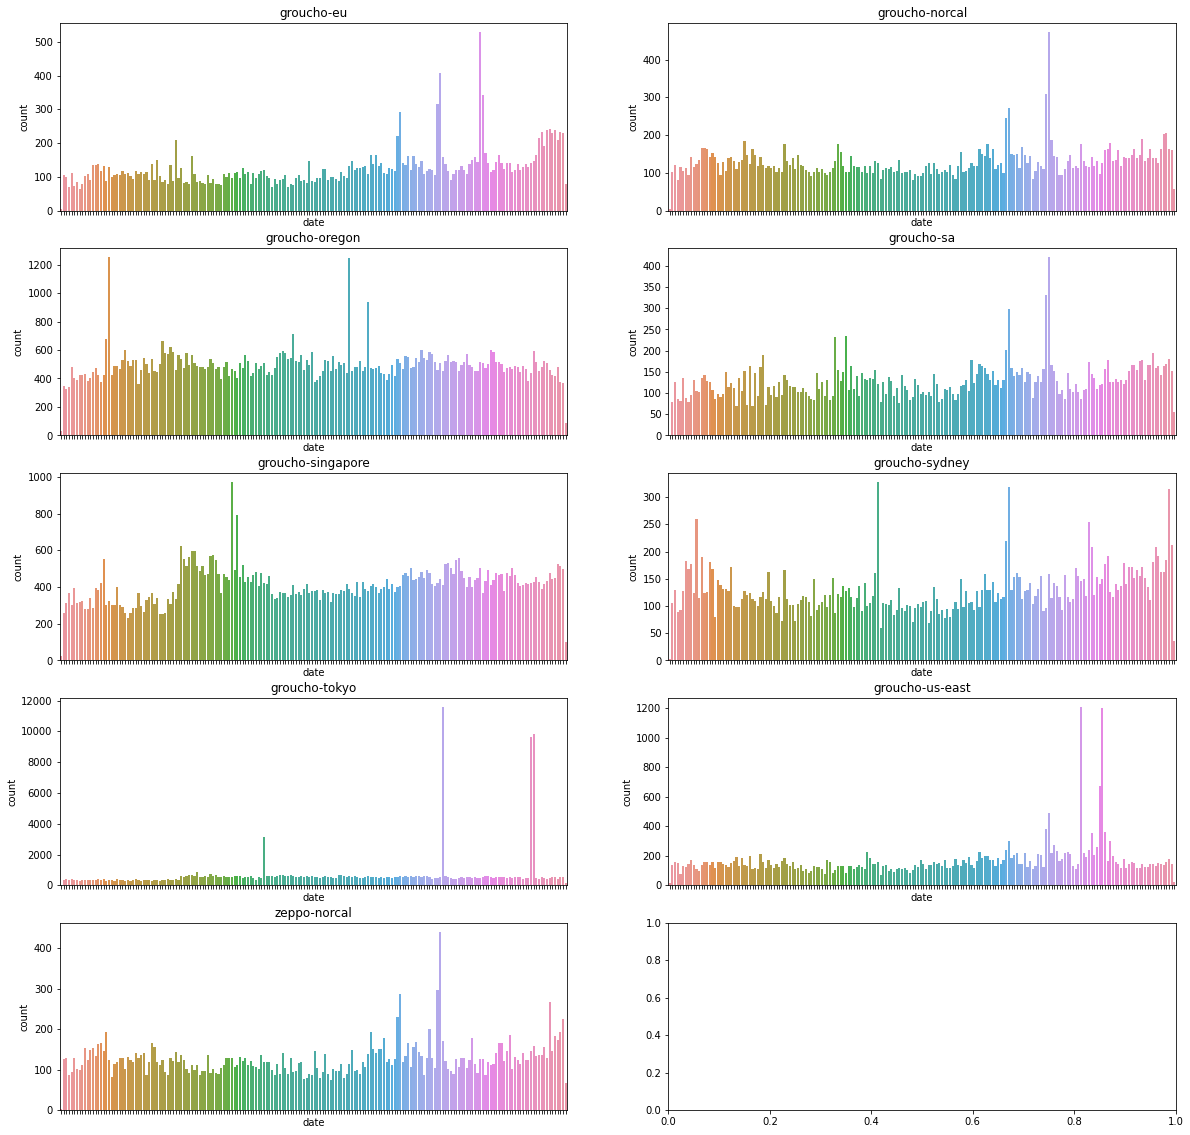

In [43]:
fig, axs = plt.subplots(5, 2)
fig.set_size_inches(20, 20)

count = 0
for host, group in df.groupby('host'):
    if count == 0:
        x, y = 0, 0
    else:
        x, y = math.floor(count / 2), count % 2
    plt.setp(axs[x, y].get_xticklabels(), visible=False)
    axs[x, y].title.set_text(host)
    sns.countplot(x='date', data=group, ax=axs[x, y])
    count += 1

In [44]:
read_date(df.groupby('host').get_group('zeppo-norcal')['date'].value_counts().index[0])

'23 Jul 2013'

In [45]:
read_date(df.groupby('host').get_group('groucho-tokyo')['date'].value_counts().index[0])

'24 Jul 2013'

In [46]:
read_date(df.groupby('host').get_group('groucho-sa')['date'].value_counts().index[0])

'23 Jul 2013'

In [47]:
read_date(df.groupby('host').get_group('groucho-norcal')['date'].value_counts().index[0])

'23 Jul 2013'

There seems to be two important days the 23rd and 24th of july where there are a lot of attacks we can maybe look at those days and get a deeper analysis. 

For deeper analysis we can either focus on
- our top attackers getting a better understanding of their patterns and targets, with a goal of trying to predict their next attacks
- notable dates where we get an influx of attacks and try to see what is causing those attacks, with a goal of trying to predict other notable dates where we might get more attacks than usual

In [48]:
top_src_df = df[df['srcstr'] == '175.146.199.252']

In [49]:
min(top_src_df['datetime'])

'8/26/13 22:26'

In [50]:
max(top_src_df['datetime'])

'8/27/13 0:27'

In [51]:
second_src_df = df[df['srcstr'] == '2.186.189.218']

In [52]:
min(second_src_df['datetime'])

'7/24/13 7:46'

In [53]:
max(second_src_df['datetime'])

'7/24/13 7:56'

In [54]:
third_src_df = df[df['srcstr'] == '203.178.148.19']

In [55]:
min(third_src_df['datetime'])

'4/13/13 19:02'

In [56]:
max(third_src_df['datetime'])

'9/8/13 5:12'